# Towards Interactive Datascience in Haskell #

### Introduction ###

Haskell and Data science - on first sight a perfect match: native function composition allows to build data transformation pipelines that are lazily executed and parallelized by default. At the same time, bugs are largely prevented at compile time by Haskell's impressive type system, and the language has native execution times that are comparable to *c*. In principle programs written in the language therefore scale from the smallest to the largest scenarios imaginable. Well what's missing then? Why is Haskell not widely used in data analytics?

One of the reasons is that Haskell misses a standardized data science environment, comparable to Python that has the defacto standard library set `numpy`, `pandas`, `scikit-learn`, and a large range of specific wrapped libraries such as `keras` and `tensorflow`. The libraries are distributed through easy-to-use package managers and explained in a plethora of tutorials, stackoverflow questions and example jupyter notebooks that provide starting points for most problems.

## [Part 1] Haskell and Jupyterlab ##

### Project Jupyter: Overview ###

For those who don't know it: Project Jupyter revolves around a messaging protocoll that standardizes interactions with little programs called 'kernels'. A user sends a code snippet to a kernel that responds with a rich media message. A frontend can immediately render the rich media response as text, images, videos or even small applications. This rich media dialogue with an execution environment can be assembled into a sequential workflow, and interlace with text to produce a human readable notebook. Notebooks have become one of the most popular ways to do and communicate data analysis.

A large software ecosystem has evolved around the Jupyter messaging protocol:
Kernels in many different languages exist (Python, Haskell, R, C++, Julia, ...). Server applications can launch kernels via web-browsers locally or for thousands of users on cloud-services. Frontends such as simple REPL-style consoles, notebooks, or desktop applications allow users to interact with the kernels.

### Conversations with a Jupyter kernel ###

IHaskell is the name of the Jupyter Haskell-kernel. It contains a little executable `ihaskell` that can receive messages in the Jupyter protocoll (via ZeroMQ for those who know it), and responds with messages once executed. Here is a little dialogue with `ihaskell`: We send the following code snippet to `ihaskell` and display the result below.

In [1]:
take 10 $ (^2) <$> [1..]

[1,4,9,16,25,36,49,64,81,100]

In jupyter parlance, we send an execute_request:

```
        >> shell.execute_request (8be63d5c-1170-495d-82da-e56272052faf) <<

        header: {username: "", version: "5.2", session: "32fe9cd0-8c37-450e-93c0-6fbd45bfdcd9",
                 msg_id: "8be63d5c-1170-495d-82da-e56272052faf", msg_type: "execute_request"}
        parent_header: Object
        channel: "shell"
        content: {silent: false, store_history: true, user_expressions: Object, allow_stdin: true,
                  stop_on_error: true, code: "take 10 $ (^2) <$> [1..]"}   <<<<<<<<<<< LOOK HERE
        metadata: Object
        buffers: Array[0]
```

and receive a display_data message as a response:

```
        << iopub.display_data (68cce1e7-4d60-4a20-a707-4bf352c4d8d2) >>

        header: {username: "", msg_type: "display_data", version: "5.0"
                 msg_id: "68cce1e7-4d60-4a20-a707-4bf352c4d8d2",
                 session: "32fe9cd0-8c37-450e-93c0-6fbd45bfdcd9",
                 date: "2018-08-02T08:14:10.245877Z"}
        msg_id: "68cce1e7-4d60-4a20-a707-4bf352c4d8d2"
        msg_type: "display_data"
        parent_header: {username: "", msg_type: "execute_request", version: "5.0",
                        msg_id: "8be63d5c-1170-495d-82da-e56272052faf",
                        session: "32fe9cd0-8c37-450e-93c0-6fbd45bfdcd9"}
        metadata: Object
        content: {data: {text/plain: "[1,4,9,16,25,36,49,64,81,100]"},  <<<<<<<<<<< LOOK HERE
                  metadata: {output_type: "display_data"}}
        buffers: Array[0]
        channel: "iopub"
```

`ihaskell` can import other haskell libraries dynamically and has some special commands to enable language extensions, print type information or to use hoogle.

## Jupyterlab ##

So what about Jupyterlab? Jupyterlab is the newest animal in the jupyter frontend zoo, and it is arguably one of the most powerful: Console, Notebook, Terminal, Text-Editor, or Image Viewer, Jupyterlab integrates these datascience building blocks into a single webbased user interface. It is setup as a modular system and allows first-class The building blocks can be assembled in a variety of ways, resembling an IDE, a classical notebook or even a GUI where all interaction with the underlying execution kernels is hidden behind graphical elements.

Naturally Haskell should be part of this! What are the potential gains? Well, first there are a ton of out-of-the-box renderers available that can be used for free by Haskell. From the default renderers (`text/markdown, image/bmp, image/gif, image/jpeg, image/png, image/svg+xml, application/json, text/html, text/latex, application/pdf, application/vnd.vega.v2+json, application/vnd.vegalite.v1+json, application/vdom.v1+json`) the most interesting is probably Vega plotting (declarative `d3.js`), but also geojson, plotly or and others are available from the list of extensions that will certainly grow.

The second point is, that Jupyterlab is easily extensible, extensions are first level packages and can literally use and modify everything that comes with the base packages. Building simple UI's that interact with an execution environment is therefore relatively simple. Enough reasons, let's finish the antipasti and get to the meat of it. Let's start with VEGA rendering from Haskell:

### Wordclouds from Haskell with Vega and Jupyterlab ###

as an example, we use here the word content of all blogposts of *Tweag.IO* that are written in markdown. Here is a little code cell that reads all `.md` files the `posts` folder and concatenates them in a single long string from which we remove some punctuation characters.

In [2]:
:ext QuasiQuotes
import System.Directory
import Data.List

fnames <- getDirectoryContents "./posts"
paths = ("./posts/"++) <$> fnames
md_files = filter (isSuffixOf ".md") paths
text <- mconcat (readFile <$> md_files)
cleanedText = filter (not . (`elem` "\n,.?!-:;\"\'")) text
take 50 cleanedText

"title Were hiring<br>(Software engineer / devops)p"

now let's define a Vega JSON as a string and fill it up with our text. A convenient way to write longer multiline strings in Haskell are QuasiQuotes. We use fString QuasiQuotes from the PyF package.

In [3]:
import Formatting
import PyF
import Data.String.QQ

let vegaString = [fString|{{
  "$schema": "https://vega.github.io/schema/vega/v4.json",
  "width": 800,
  "height": 400,
  "padding": 0,

  "data": [
    {{
      "name": "table",
      "values": [
         "{take 20000 cleanedText}"
      ],
      "transform": [
        {{
          "type": "countpattern",
          "field": "data",
          "case": "upper",
          "pattern": "[\\\\w']{{3,}}",
          "stopwords": "(\\\\d+|youll|looking|like|youre|etc|yet|need|cant|ALSO|STILL|ISNT|Want|Lots|HTTP|HTTPS|i|me|my|myself|we|us|our|ours|ourselves|you|your|yours|yourself|yourselves|he|him|his|himself|she|her|hers|herself|it|its|itself|they|them|their|theirs|themselves|what|which|who|whom|whose|this|that|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|will|would|should|can|could|ought|i'm|you're|he's|she's|it's|we're|they're|i've|you've|we've|they've|i'd|you'd|he'd|she'd|we'd|they'd|i'll|you'll|he'll|she'll|we'll|they'll|isn't|aren't|wasn't|weren't|hasn't|haven't|hadn't|doesn't|don't|didn't|won't|wouldn't|shan't|shouldn't|can't|cannot|couldn't|mustn't|let's|that's|who's|what's|here's|there's|when's|where's|why's|how's|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|upon|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|say|says|said|shall)"
        }},
        {{
          "type": "formula", "as": "angle",
          "expr": "[0, 90][~~(random() * 3)]"
        }},
        {{
          "type": "formula", "as": "weight",
          "expr": "if(datum.text=='VEGA', 600, 300)"
        }}
      ]
    }}
  ],

  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "range": ["#3e4593", "#bc3761", "#39163d", "#2a1337"]
    }}
  ],

  "marks": [
    {{
      "type": "text",
      "from": {{"data": "table"}},
      "encode": {{
        "enter": {{
          "text": {{"field": "text"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "alphabetic"}},
          "fill": {{"scale": "color", "field": "text"}}
        }},
        "update": {{
          "fillOpacity": {{"value": 1}}
        }},
        "hover": {{
          "fillOpacity": {{"value": 0.5}}
        }}
      }},
      "transform": [
        {{
          "type": "wordcloud",
          "size": [800, 400],
          "text": {{"field": "text"}},
          "rotate": {{"field": "datum.angle"}},
          "font": "Helvetica Neue, Arial",
          "fontSize": {{"field": "datum.count"}},
          "fontWeight": {{"field": "datum.weight"}},
          "fontSizeRange": [12, 56],
          "padding": 2
        }}
      ]
    }}
  ]
}}|]

We display this JSON string with the native Jupyterlab JSON renderer here for convenience.

In [4]:
import qualified IHaskell.Display as D
D.Display [D.json vegaString]

now let's procedede to plot this JSON as a Vega plot:

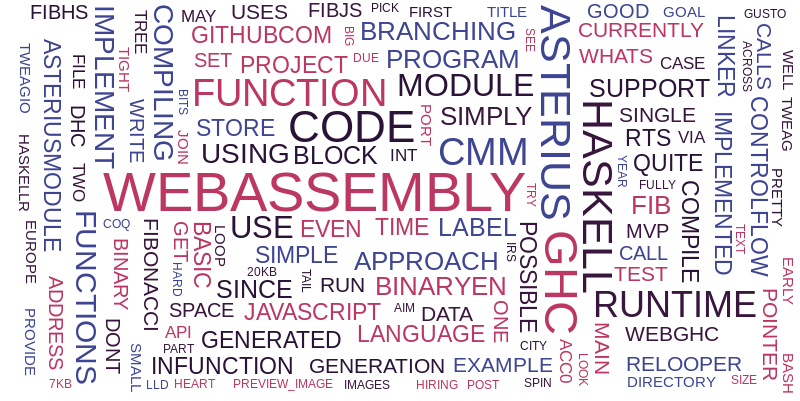

In [5]:
D.Display [D.vegalite vegaString]